In [85]:
## Version futuresales lib required = 0.1.11

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.11
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [86]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns

In [87]:
RUN_NAME = 'FSRES-36'

In [88]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    run=RUN_NAME
)  # your credentials

https://app.neptune.ai/denissimo/FS-Results/e/FSRES-36
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [89]:
task_df = {}

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [90]:
run['dump/residuals'].download()
report = from_pickle('./residuals.pkl')
report['object_id'] = task_df['dynamic'].index
report['residuals'] = report['predicted'] - report['valid_target']

In [91]:
report

,valid_target,residuals,predicted,object_id
0,0.0,0.013593,0.013593,54
1,0.0,0.028103,0.028103,114
2,0.0,0.013593,0.013593,174
3,0.0,0.013593,0.013593,234
4,0.0,0.028103,0.028103,294
...,...,...,...,...
422572,0.0,0.013735,0.013735,1330036
422573,0.0,0.013735,0.013735,1330090
422574,0.0,0.013735,0.013735,1330142
422575,0.0,0.013735,0.013735,1330150


In [92]:
report = report.merge(idx, on='object_id', how='left')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


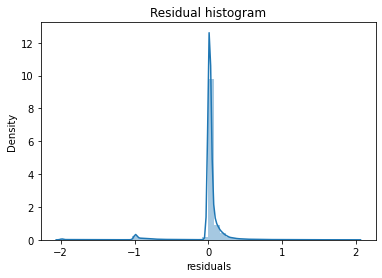

In [93]:
run['analysis/residuals/plots/histogram'].upload(File.as_image(sns.distplot(report[abs(report.residuals) < 2].residuals).set_title('Residual histogram').figure))

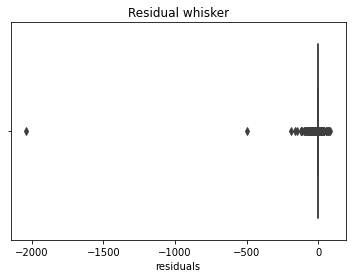

In [94]:
run['analysis/residuals/plots/whisker'].upload(File.as_image(sns.boxplot(data=report, x='residuals').set_title('Residual whisker').figure))

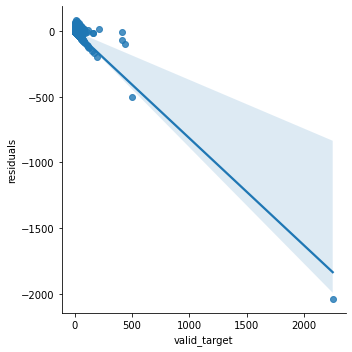

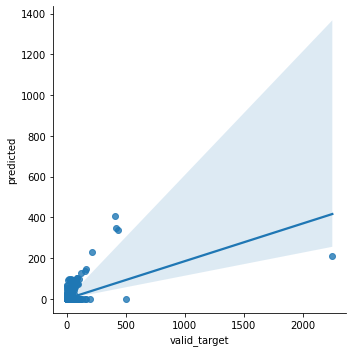

In [95]:
run['analysis/residuals/plots/dependecies'] = {
    'target_residual': File.as_image(sns.lmplot(data=report, x='valid_target', y='residuals').figure),
    'target_predicted': File.as_image(sns.lmplot(data=report, x='valid_target', y='predicted').figure),
}

In [96]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])

In [97]:
giant_test, percent_str =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.9758326078126625 of error


In [98]:
giant_test

,id,valid_target,residuals,predicted,object_id,Unnamed: 0,item_name,item_id,item_category_id,shop_name,shop_id,item_category_name,abs_residuals,part
342837,342837,12.0,-11.986407,0.013593,1068052,1068052,Assassin's Creed: Синдикат. Специальное издани...,1583,20,"Уфа ТК ""Центральный""",52,Игры - PS4,11.986407,0.000029
348025,348025,12.0,-11.986407,0.013593,1076904,1076904,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",10202,20,"Москва ТК ""Буденовский"" (пав.К7)",24,Игры - PS4,11.986407,0.000029
342793,342793,12.0,-11.986407,0.013593,1067982,1067982,"Assassin's Creed: Синдикат. Грачи [PS4, русска...",1581,20,"СПб ТК ""Невский Центр""",42,Игры - PS4,11.986407,0.000029
347497,347497,12.0,-11.986407,0.013593,1076043,1076043,"Uncharted: Натан Дрейк. Коллекция [PS4, русска...",7223,20,"Балашиха ТРК ""Октябрь-Киномир""",3,Игры - PS4,11.986407,0.000029
381999,381999,12.0,-11.986407,0.013593,1178000,1178000,Мягкая игрушка Adventure Time Финн 18см,15239,63,"Москва ""Распродажа""",20,Подарки - Мягкие игрушки,11.986407,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341395,341395,152.0,-151.986407,0.013593,1065282,1065282,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",10201,28,"СПб ТК ""Невский Центр""",42,Игры PC - Дополнительные издания,151.986407,0.004594
341384,341384,166.0,-165.986407,0.013593,1065265,1065265,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",10201,28,"Москва ТРК ""Атриум""",25,Игры PC - Дополнительные издания,165.986407,0.005479
300988,300988,194.0,-193.986265,0.013735,900009,900009,Kaspersky Internet Security для Android Russia...,4201,75,Выездная Торговля,9,Программы - Для дома и офиса,193.986265,0.007483
408261,408261,500.0,-499.963349,0.036651,1244532,1244532,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,Интернет-магазин ЧС,12,"Подарки - Сумки, Альбомы, Коврики д/мыши",499.963349,0.049708


In [99]:
run['analysis/residuals/top_worst/magic_string'] = percent_str
run['analysis/residuals/top_worst/raw_giants'].upload(File.as_pickle(giant_test))


serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [100]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'object_id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'valid_target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
run['analysis/residuals/top_worst/top_50_objects'].upload(File.as_html(top_50))

In [101]:
top_15_shops = (giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_shops'].upload(File.as_html(top_15_shops))

In [102]:
top_15_items= (giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_items'].upload(File.as_html(top_15_items))

In [103]:
top_50.reset_index().set_index('object_id')

shop_id item_id                              shop_name  \
                                                                   
object_id                                                          
680379         39   21811  РостовНаДону ТРК "Мегацентр Горизонт"   
1071129         9    3351                      Выездная Торговля   
1140102        42   20386                 СПб ТК "Невский Центр"   
1065277        37   10201                  Новосибирск ТЦ "Мега"   
1095860        20   11526                    Москва "Распродажа"   
1244538        18   20949                   Красноярск ТЦ "Июнь"   
1326980        20   14957                    Москва "Распродажа"   
1065252        12   10201                    Интернет-магазин ЧС   
859315         55    4865               Цифровой склад 1С-Онлайн   
1234231        31   14839                Москва ТЦ "Семеновский"   
1229147        47    5824                 Сургут ТРЦ "Сити Молл"   
1285880        20   15047                    Москва "Распродажа"   
604959         39   11055  РостовНаДону ТРК "Мегацентр Горизонт"   
1065266        26   10201            Москва ТЦ "Ареал" (Беляево)   
1076071        31    7223                Москва ТЦ "Семеновский"   
1068042        42    1583                 СПб ТК "Невский Центр"   
1317268        28    9250        Москва ТЦ "МЕГА Теплый Стан" II   
1065262        22   10201                     Москва Магазин С21   
1066509         9   15069                      Выездная Торговля   
1076082        42    7223                 СПб ТК "Невский Центр"   
1068025        25    1583                    Москва ТРК "Атриум"   
1244535        15   20949                   Калуга ТРЦ "XXI век"   
1266295        55    7966               Цифровой склад 1С-Онлайн   
1071266        26    3445            Москва ТЦ "Ареал" (Беляево)   
1076065        25    7223                    Москва ТРК "Атриум"   
1326920        20   14956                    Москва "Распродажа"   
1065271        31   10201                Москва ТЦ "Семеновский"   
1244562        42   20949                 СПб ТК "Невский Центр"   
1095849         9   11526                      Выездная Торговля   
1076142        42    7224                 СПб ТК "Невский Центр"   
1285869         9   15047                      Выездная Торговля   
1287860        20   16843                    Москва "Распродажа"   
1317912        12   11372                    Интернет-магазин ЧС   
1065246         6   10201             Воронеж (Плехановская, 13)   
1321209         9   13246                      Выездная Торговля   
1318032        12   13753                    Интернет-магазин ЧС   
528429          9    7018                      Выездная Торговля   
519969          9    4719                      Выездная Торговля   
1076125        25    7224                    Москва ТРК "Атриум"   
1244545        25   20949                    Москва ТРК "Атриум"   
525789          9    6503                      Выездная Торговля   
1076905        25   10202                    Москва ТРК "Атриум"   
1076922        42   10202                 СПб ТК "Невский Центр"   
1321220        20   13246                    Москва "Распродажа"   
1287849         9   16843                      Выездная Торговля   
1065282        42   10201                 СПб ТК "Невский Центр"   
1065265        25   10201                    Москва ТРК "Атриум"   
900009          9    4201                      Выездная Торговля   
1244532        12   20949                    Интернет-магазин ЧС   
1317972        12   11373                    Интернет-магазин ЧС   

                                                   item_name   predicted  \
                                                                    mean   
object_id                                                                  
680379                                            ШАКАЛ (BD)    0.013735   
1071129                        FIFA 16 [PS4, русская версия]    0.013593   
1140102    Фигурка Assass

{1065282, 900009, 1065265, 1317972, 1244532}
{1321220, 1076905, 1287849, 1076922, 525789}
{519969, 1244545, 528429, 1318032, 1076125}
{1285869, 1287860, 1317912, 1321209, 1065246}
{1326920, 1095849, 1076142, 1244562, 1065271}
{1076065, 1071266, 1266295, 1244535, 1068025}
{1068042, 1066509, 1065262, 1076082, 1317268}
{1076071, 1065266, 1285880, 1229147, 604959}
{1326980, 1065252, 859315, 1234231, 1244538}
{1140102, 1095860, 1071129, 680379, 1065277}


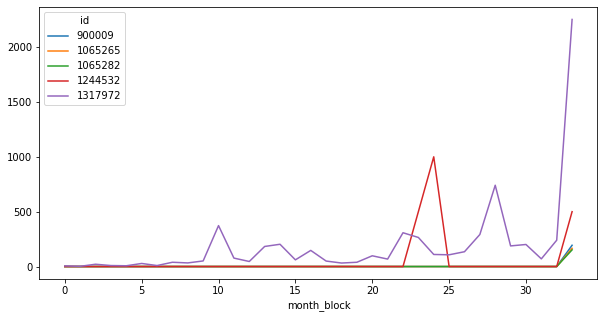

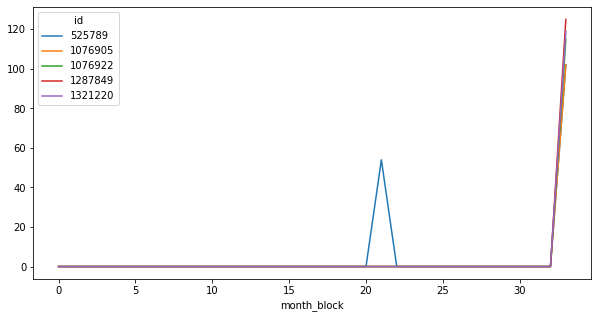

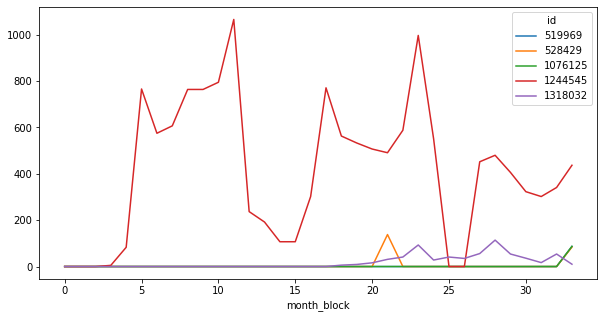

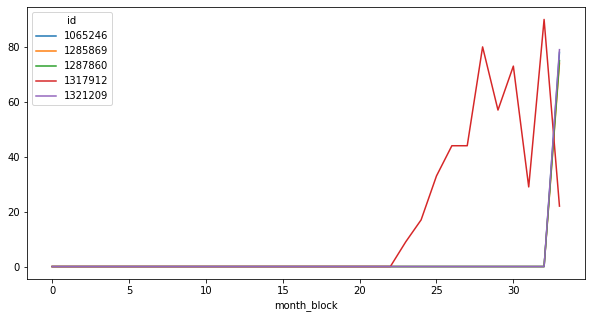

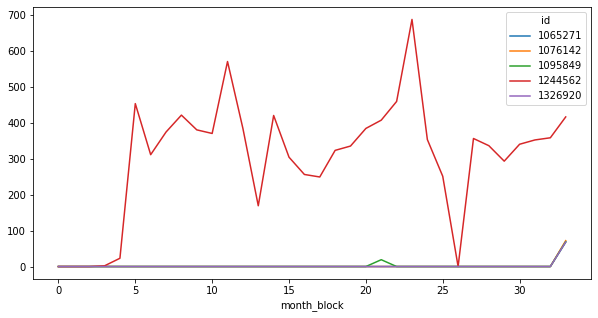

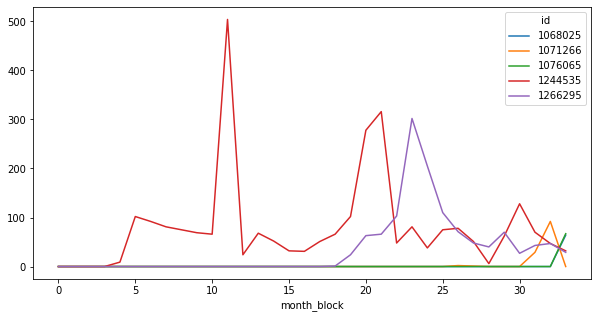

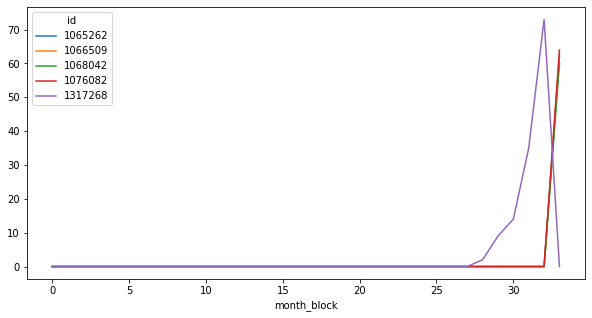

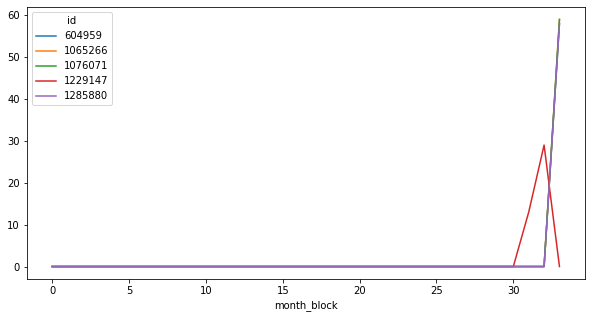

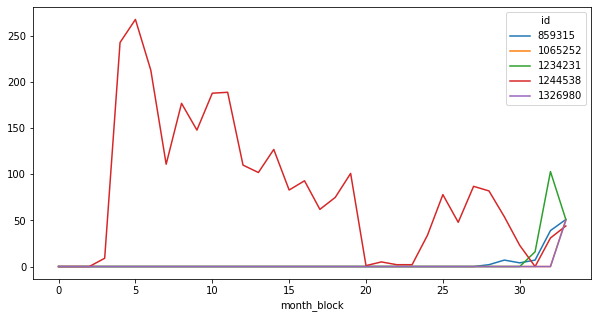

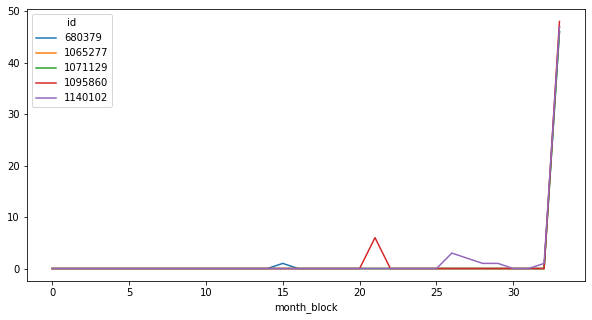

In [104]:
for i in range(0, 10):
    id_slice = top_50.reset_index().set_index('object_id').index.to_list()[-5 - 5*i: -5 - 5*(i - 1)] if i != 0 else top_50.reset_index().set_index('object_id').index.to_list()[-5: None]
    print(set(id_slice) & set(task_df['dynamic'].index))
    fig = task_df['dynamic'][task_df['dynamic'].index.isin(id_slice)].transpose().plot(figsize=(10, 5)).figure
    run[f'analysis/residuals/plots/top_{5*i}-{5*(i + 1)}_items'].upload(File.as_image(fig))

In [105]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.


All 38 operations synced, thanks for waiting!
